In [1]:
import sys
import ee, geemap
import ipywidgets as widgets
import habitat_pl.viz.corine as corine
import importlib
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay

ee.Authenticate()
ee.Initialize(project='agh-ml-2025')
importlib.reload(corine)

# to keep things consistent
RANDOM_SEED = 123
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

d:\studia\Y5S1\ML_for_Space_Tech_2\.venv\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.5) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [ ]:
szpn_geom = ee.Geometry.Polygon([[ [23.858185,51.022394],[23.852348,51.018938],[23.825226,51.016779],[23.808403,51.00749],[23.811493,50.999713],[23.825912,50.951074],[23.769608,50.944584],[23.772011,50.93182],[23.804626,50.922298],[23.814583,50.914074],[23.856468,50.917537],[23.869514,50.909095],[23.892517,50.911909],[23.90522,50.887875],[23.935776,50.891123],[23.942986,50.903466],[23.992424,50.905414],[23.996201,50.919918],[23.979034,50.94134],[23.950195,50.941556],[23.948135,50.962103],[23.962898,50.974427],[23.942986,50.992366],[23.923073,51.001441],[23.898354,51.007274],[23.879814,51.015051],[23.870201,51.022826],[23.858185,51.022394] ]])
region = ee.FeatureCollection([ee.Feature(szpn_geom)])

# Annual Satellite Embedding (example: 2021)
emb = (ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
       .filterDate('2021-05-01','2021-07-01')
       .filterBounds(region)
       .mosaic()
       .clip(region))

# Visualize (pseudo-RGB from embedding bands)
m = geemap.Map()
m.centerObject(region, 8)
m.addLayer(emb, {'min':-0.3,'max':0.3,'bands':['A01','A16','A09']}, 'Embeddings 2021')

# Loads CORINE Land Cover 2018 raster (44 classes, 100 m resolution).
clc = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(region)

# Remaps CORINE class codes (111…523) to sequential indices (1…44).
clc_idx = clc.remap(corine.codes, list(range(1, len(corine.codes)+1))).rename('landcover_idx')

In [3]:
# Get GSE samples from 2021 (same as map visualization)
gse_2021 = (ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
            .filterDate('2021-01-01', '2022-01-01')
            .filterBounds(region)
            .mosaic()
            .clip(region))

gse_bands = [b for b in gse_2021.bandNames().getInfo() if b.startswith('A')]

# Extract CORINE labels for the same region
corine_data = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(region)
# Remap CORINE codes to sequential indices
corine_idx = corine_data.remap(corine.codes, list(range(1, len(corine.codes)+1))).rename('landcover_idx')
# Delete pixels with no data
gse_masked = gse_2021.updateMask(corine_idx.gt(0))

In [4]:
# CORINE forest classes
FOREST_CODES = [311, 312, 313]

# Create forest-only mask
forest_mask = corine_data.remap(
    FOREST_CODES,
    [1, 2, 3]   # map to class indices
).rename('forest_class')

# Mask embeddings to forest pixels only
gse_forest = gse_2021.updateMask(forest_mask.gt(0))

print("✓ Forest-only embeddings created")


✓ Forest-only embeddings created


In [5]:
# Stack embeddings and labels
stack = gse_forest.select(gse_bands).addBands(forest_mask)

# Random spatial sampling
samples = stack.stratifiedSample(
    numPoints=1500,          # PER CLASS
    classBand='forest_class',
    region=region.geometry(),
    scale=100,
    seed=RANDOM_SEED,
    geometries=False
)


print("✓ Samples collected:", samples.size().getInfo())


✓ Samples collected: 4500


In [6]:
# Convert to client-side
samples_fc = samples.getInfo()

# Extract feature matrix and labels
X = []
y = []

for f in samples_fc['features']:
    props = f['properties']
    X.append([props[b] for b in gse_bands])
    y.append(props['forest_class'] - 1)  # 0,1,2

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Check class distribution
unique, counts = np.unique(y, return_counts=True)
print("\nClass distribution:")
class_names = ['Broadleaf (311)', 'Coniferous (312)', 'Mixed (313)']
for cls, count, name in zip(unique, counts, class_names):
    print(f"  {name}: {count} samples ({count/len(y)*100:.1f}%)")


X shape: (4500, 64)
y shape: (4500,)

Class distribution:
  Broadleaf (311): 1500 samples (33.3%)
  Coniferous (312): 1500 samples (33.3%)
  Mixed (313): 1500 samples (33.3%)


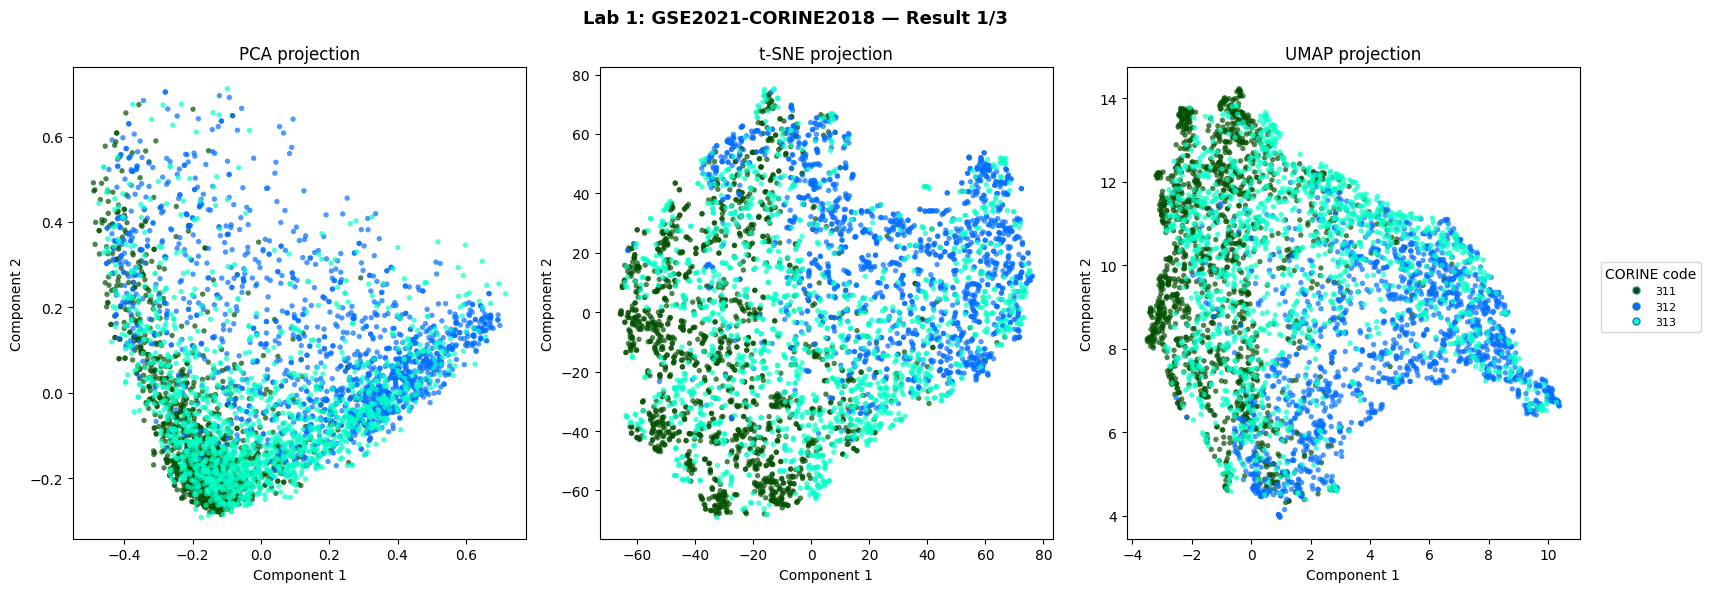

In [7]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
## variables for dimensionality reduction
TSNE_PERPLEXITY = 30
UMAP_N_NEIGHBORS = 20
UMAP_MIN_DIST = 0.2


# PCA (2D)
pca_2d = PCA(n_components=2, random_state=RANDOM_SEED).fit_transform(X)

# t-SNE (2D)
tsne_2d = TSNE(n_components=2, perplexity=TSNE_PERPLEXITY, learning_rate='auto',
               init='pca', random_state=RANDOM_SEED).fit_transform(X)

# UMAP (2D)
umap_2d = umap.UMAP(n_neighbors=UMAP_N_NEIGHBORS, min_dist=UMAP_MIN_DIST,
                    n_components=2, metric='euclidean', random_state=RANDOM_SEED).fit_transform(X)


FOREST_CLASS_CODES = [311, 312, 313]  # Broadleaf, Coniferous, Mixed
idx_to_color = {0: "#005000", 1: "#006EFF", 2: "#00FFC8"}  # green, blue, red
idx_to_code = {i: code for i, code in enumerate(FOREST_CLASS_CODES)}
code_to_name = {311: 'Broad-leaved forest', 312: 'Coniferous forest', 313: 'Mixed forest'}

unique_idx = sorted(np.unique(y))

# Plotting with code-only labels
fig, axes = plt.subplots(1, 3, figsize=(16, 6), dpi=100)
for ax, xy, name in zip(
    axes,
    [pca_2d, tsne_2d, umap_2d],
    ['PCA projection','t-SNE projection','UMAP projection']
):
    for cls in unique_idx:
        m = (y == cls)
        if not m.any():
            continue
        ax.scatter(
            xy[m, 0], xy[m, 1],
            s=15, alpha=0.7,
            color=idx_to_color.get(cls, '#000000'),
            edgecolors='none'
        )
    ax.set_title(name, fontsize=12)
    ax.set_xlabel('Component 1', fontsize=10)
    ax.set_ylabel('Component 2', fontsize=10)
    ax.grid(False)

handles, labels = [], []
for cls in unique_idx:
    handles.append(plt.Line2D([0],[0], marker='o', linestyle='',
                              markersize=5, markerfacecolor=idx_to_color.get(cls, '#000000')))
    labels.append(str(idx_to_code.get(cls, cls)))
fig.legend(handles, labels, title="CORINE code", bbox_to_anchor=(1.0, 0.5), 
           loc='center left', fontsize=8, ncol=1)

fig.suptitle("Lab 1: GSE2021-CORINE2018 — Result 1/3", fontsize=13, weight='bold')
plt.tight_layout()
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

# Split into train (70%), temp (30%)
Xtr, Xtemp, ytr, ytemp = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y
)

# Split temp into test (50%) and val (50%) = 15% each of original
Xte, Xval, yte, yval = train_test_split(
    Xtemp, ytemp, test_size=0.5, random_state=RANDOM_SEED, stratify=ytemp
)

print("✓ Train/test/val split completed")
print(f"Training set: {Xtr.shape[0]} samples")
print(f"Test set: {Xte.shape[0]} samples")
print(f"Validation set: {Xval.shape[0]} samples")

# Store PCA projections for visualization
Xp = pca_2d
Xn = X

✓ Train/test/val split completed
Training set: 3150 samples
Test set: 675 samples
Validation set: 675 samples


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    SVC(random_state=RANDOM_SEED),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit grid search
print("Starting grid search...")
grid_search.fit(Xtr, ytr)

# Best parameters and score
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
yp_tuned = grid_search.predict(Xte)
print("\nTest set accuracy:", grid_search.score(Xte, yte))
print(classification_report(yte, yp_tuned))


Starting grid search...
Fitting 5 folds for each of 90 candidates, totalling 450 fits

Best parameters: {'C': 1000, 'gamma': 'scale', 'kernel': 'poly'}
Best cross-validation score: 0.822857142857143

Test set accuracy: 0.8222222222222222
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       225
           1       0.88      0.86      0.87       225
           2       0.81      0.75      0.78       225

    accuracy                           0.82       675
   macro avg       0.82      0.82      0.82       675
weighted avg       0.82      0.82      0.82       675



In [10]:
from sklearn.ensemble import RandomForestClassifier


# Define parameter grid for RandomForestClassifier
rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10, 15, 20]
}

rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    rf_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

print("Starting Random Forest grid search...")
rf_grid_search.fit(Xtr, ytr)

print("\nBest parameters:", rf_grid_search.best_params_)
print("Best cross-validation score:", rf_grid_search.best_score_)

# Evaluate on test set
yp_rf_tuned = rf_grid_search.predict(Xte)
print("\nTest set accuracy:", rf_grid_search.score(Xte, yte))
print(classification_report(yte, yp_rf_tuned))

Starting Random Forest grid search...
Fitting 5 folds for each of 90 candidates, totalling 450 fits

Best parameters: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 300}
Best cross-validation score: 0.7838095238095237

Test set accuracy: 0.7748148148148148
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       225
           1       0.79      0.88      0.84       225
           2       0.73      0.66      0.69       225

    accuracy                           0.77       675
   macro avg       0.77      0.77      0.77       675
weighted avg       0.77      0.77      0.77       675




Test set accuracy: 0.8133333333333334
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       225
           1       0.84      0.88      0.86       225
           2       0.80      0.70      0.75       225

    accuracy                           0.81       675
   macro avg       0.81      0.81      0.81       675
weighted avg       0.81      0.81      0.81       675



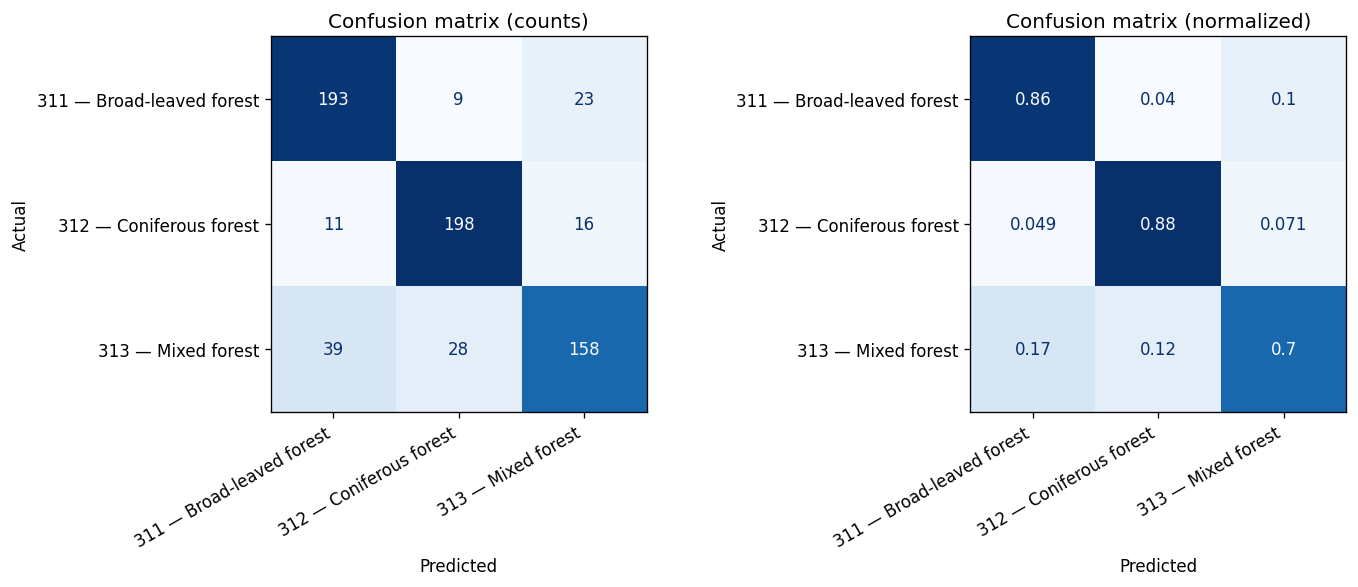

In [11]:
# Visualize forests: actual (fill) vs predicted (outline) on PCA
# Uses existing variables: Xp, Xn, y, svm, idx_to_color, idx_to_code, code_to_name
svm = SVC(C=100, gamma='scale', kernel='poly', random_state=RANDOM_SEED)
svm.fit(Xtr, ytr)

# Predict all points using the trained SVM
y_pred_te = svm.predict(Xte)
print("\nTest set accuracy:", svm.score(Xte, yte))
print(classification_report(yte, y_pred_te))
# Use ConfusionMatrixDisplay from sklearn.metrics to visualize confusion matrices

classes_idx = [int(c) for c in unique_idx]
class_labels = [f"{idx_to_code[i]} — {code_to_name.get(idx_to_code[i], str(idx_to_code[i]))}" for i in classes_idx]

# Choose the predictions to analyze (use yp_rf; switch to yp_tuned or yp_xgb if needed)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=120)

# Raw counts
ConfusionMatrixDisplay.from_predictions(
    yte, y_pred_te,
    labels=classes_idx,
    display_labels=class_labels,
    ax=axes[0],
    cmap='Blues',
    colorbar=False
)
axes[0].set_title('Confusion matrix (counts)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Normalized by true class (recall per class)
ConfusionMatrixDisplay.from_predictions(
    yte, y_pred_te,
    labels=classes_idx,
    display_labels=class_labels,
    normalize='true',
    ax=axes[1],
    cmap='Blues',
    colorbar=False
)
axes[1].set_title('Confusion matrix (normalized)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

for ax in axes:
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

plt.tight_layout()
plt.show()


Test set accuracy: 0.8691111111111111
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1500
           1       0.89      0.93      0.91      1500
           2       0.86      0.77      0.81      1500

    accuracy                           0.87      4500
   macro avg       0.87      0.87      0.87      4500
weighted avg       0.87      0.87      0.87      4500



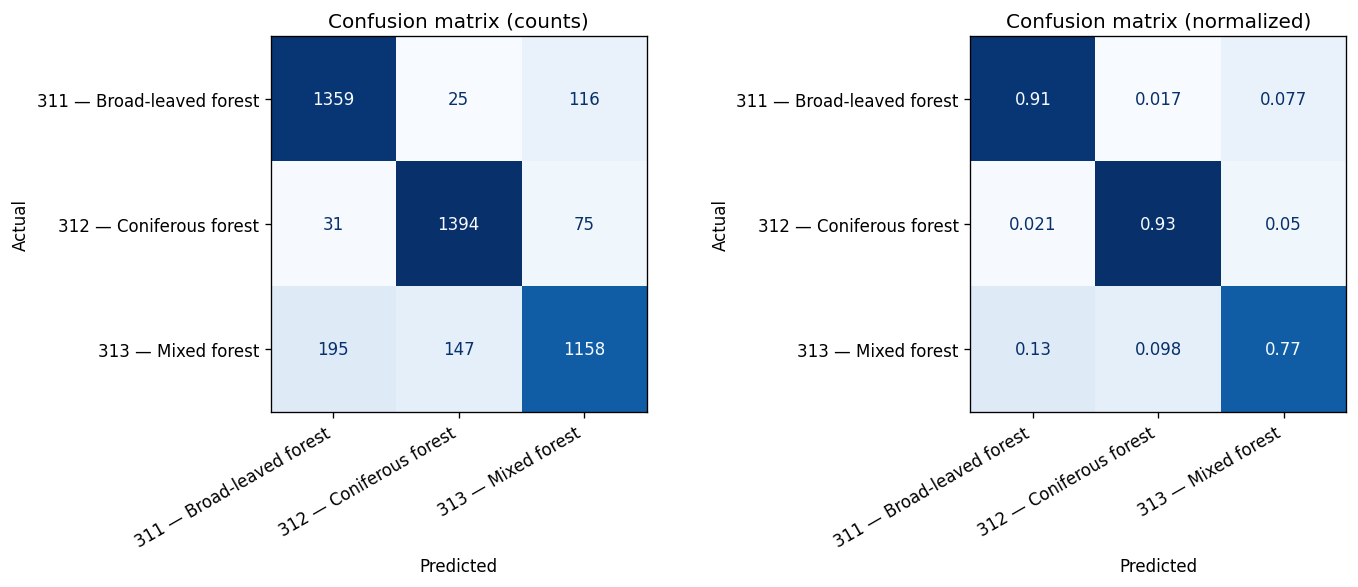

In [12]:
# Use ConfusionMatrixDisplay from sklearn.metrics to visualize confusion matrices
y_pred_all = svm.predict(Xn)
print("\nTest set accuracy:", svm.score(Xn, y))
print(classification_report(y, y_pred_all))

classes_idx = [int(c) for c in unique_idx]
class_labels = [f"{idx_to_code[i]} — {code_to_name.get(idx_to_code[i], str(idx_to_code[i]))}" for i in classes_idx]

# Choose the predictions to analyze (use yp_rf; switch to yp_tuned or yp_xgb if needed)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=120)

# Raw counts
ConfusionMatrixDisplay.from_predictions(
    y, y_pred_all,
    labels=classes_idx,
    display_labels=class_labels,
    ax=axes[0],
    cmap='Blues',
    colorbar=False
)
axes[0].set_title('Confusion matrix (counts)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Normalized by true class (recall per class)
ConfusionMatrixDisplay.from_predictions(
    y, y_pred_all,
    labels=classes_idx,
    display_labels=class_labels,
    normalize='true',
    ax=axes[1],
    cmap='Blues',
    colorbar=False
)
axes[1].set_title('Confusion matrix (normalized)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

for ax in axes:
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

plt.tight_layout()
plt.show()

In [13]:
# Get the codes present in our forest samples
present_codes = FOREST_CLASS_CODES  # [311, 312, 313]
palette = [idx_to_color[i] for i in range(len(present_codes))]  # Use existing color mapping
idx = list(range(len(present_codes)))

# Create prediction image from our SVM model
# We need to apply the model to the entire forest area
stack_for_prediction = gse_forest.select(gse_bands)

def classify_pixel(pixel):
    # This would need to be done client-side in practice
    # For now, we'll create a placeholder
    return forest_mask

# For visualization, remap forest_mask to match our class indices
pred_idx = forest_mask.remap([1, 2, 3], [0, 1, 2]).rename("forest_idx")

# CORINE 2018 forest classes only
clc_2018 = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(region)
clc_forest = clc_2018.updateMask(clc_2018.eq(311).Or(clc_2018.eq(312)).Or(clc_2018.eq(313)))
clc_idx_shared = clc_forest.remap(present_codes, idx).rename('forest_idx')

# Map
m_map = geemap.Map()
m_map.centerObject(region, 10)
m_map.addLayer(
    pred_idx,
    {"min": 0, "max": 2, "palette": palette},
    "Forest classes (reference data)",
    True
)
m_map.addLayer(
    clc_idx_shared,
    {"min": 0, "max": 2, "palette": palette},
    "CORINE 2018 forest classes",
    False
)

# Legend based on forest codes
legend_items = {
    f"{code} – {code_to_name[code]}": idx_to_color[i]
    for i, code in enumerate(present_codes)
}
m_map.add_legend(
    title="Forest classes (CORINE)",
    legend_dict=legend_items,
    position="bottomright",
)

m_map


Map(center=[50.95355089115336, 23.886449717922808], controls=(WidgetControl(options=['position', 'transparent_…